In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

#assert we are using tensorflow 2 
print("TensorFlow version:", tf.__version__)

# Load and preprocess the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape the input data to be 4D (batch_size, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Define the CNN architecture, same architecture as in https://www.tensorflow.org/tutorials/quickstart/advanced
# We make use of  Convolution layer in order to treat the image with not too much parameters
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes (0-9)
])

# We use sparse_categorical_cross_entropy because it is a classification problem
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)


TensorFlow version: 2.5.0
Epoch 1/5
844/844 [==============================] - 40s 41ms/step - loss: 0.1613 - accuracy: 0.9525 - val_loss: 0.0736 - val_accuracy: 0.9780
Epoch 2/5
844/844 [==============================] - 32s 37ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.0635 - val_accuracy: 0.9835
Epoch 3/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 0.0710 - val_accuracy: 0.9820
Epoch 4/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.0608 - val_accuracy: 0.9845
Epoch 5/5
844/844 [==============================] - 33s 39ms/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0591 - val_accuracy: 0.9858


In [85]:
# # Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

313/313 [==============================] - 3s 8ms/step - loss: 0.0608 - accuracy: 0.9820
Test accuracy: 0.982


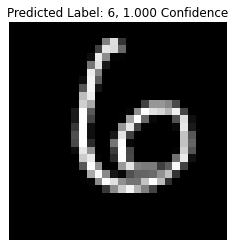

In [86]:
import matplotlib.pyplot as plt
import numpy as np

"i = 7,8,115,4048"

# We choose an index from the test set
index = 100

# Make the predictions on the test set
predictions = model.predict(x_test)

# we get the predicted label for the chosen index
predicted_label = np.argmax(predictions[index])
confidence = np.max(predictions[index])

# Finally, we display the test image
plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence')
plt.axis('off')
plt.show()


# Adversarial Example

We aim to perturbate the prediction of a model using a slight perturbation in the input. This can always be done in the linear case, provided that the dimension is big enough. Indeed, for a weight vector $w$, an input $x$, a target $y$ and a perturbation $\eta$ we have :

$$ \langle w, x+ \eta \rangle=  \langle w, x \rangle + \langle w, \eta \rangle = y + \langle w, \eta \rangle$$
The output perturbation is $\langle w, \eta \rangle$. The optimal direction to maximize this dot product under the constraint $||\eta||_{\infty} \leq cst $ is $\text{sign}(w)$.
In this case, if the dimension is $n$ and the average magnitude of the coordinates of $w$ is $m$ then the output perturbation is $\varepsilon m n$, where $ \varepsilon = ||\eta||_{\infty}$.

_Curse of dimensionnality_ : This perturbation grows with the dimension $n$ even if $\varepsilon$ is fixed. With large dimensionnal input (such as images) we can make large perturbation of the output and change the output by adding an imperceptible noise $\eta$ with a well-chosen direction.

### Non-linear case : 
In the non-linear case there are activation functions inside the network, we consider that those functions and the resulting network are "too linear". This is especially true for ReLu activation function and the network we considered in this example (only 2 hidden layers). Therefore, linearizing the model and using the same technique should create acceptable adversarial input. For a given set of parameter $\theta$ of the model, the cost $J(\theta, x, y)$ can be approximated by $\langle \nabla_x J(\theta, x, y) , x \rangle$ and we are back to the linear case with $w = \nabla_x J(\theta, x, y)$

In [87]:
def compute_input_gradient(model, input_image, class_index=0):
    input_image = tf.convert_to_tensor(input_image)
    input_image = tf.expand_dims(input_image, axis=0)
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)   # in order to keep a trace of the operations
        predictions = model(input_image)
        predicted_prob = predictions[0, class_index]
    
    input_gradient = tape.gradient(predicted_prob, input_image)
    input_gradient = tf.squeeze(input_gradient, axis=0)
    return input_gradient.numpy()  

# Example usage:
# model: The trained TensorFlow/Keras model
# input_image: The input image for which we want to compute the gradient
input_image = x_test[index]

# Compute the gradient
gradient = compute_input_gradient(model, input_image, class_index=1)


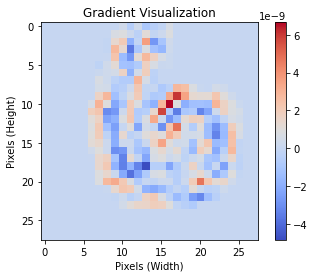

In [88]:
import matplotlib.pyplot as plt

# We assume gradient contains the gradient values in NumPy array format

# Plot the gradient
plt.imshow(gradient, cmap='coolwarm')
plt.colorbar()
plt.title('Gradient Visualization')
plt.xlabel('Pixels (Width)')
plt.ylabel('Pixels (Height)')
plt.show()


**Generation of our first adversarial image**

In [89]:
epsilon = 0.2  # Hyperparameter (small value)

reshaped_gradient = tf.reshape(gradient, input_image.shape)

# Add the sign of the gradient to the input image + a small epsilon value
adversarial_image = input_image + tf.sign(reshaped_gradient) * epsilon

# Clip the values of the adversarial image to be in (0, 1)
adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

adversarial_image_np = adversarial_image.numpy()
adversarial_image_np = np.reshape(adversarial_image_np, (1, 28, 28, 1))

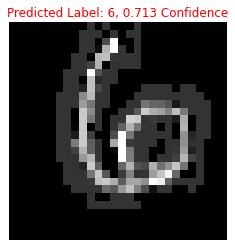

In [90]:
adversarial_image_tensor = tf.convert_to_tensor(adversarial_image_np)

predictions = model(adversarial_image_tensor)

# Get the predicted label and confidence and plot the image
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)
plt.imshow(adversarial_image_np.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence', fontsize=12, color='red')

# Show the image with the predicted label
plt.show()

Let us now generate more adversarial images

In [91]:
def generate_adversarial_image(model, input_image, target_class, epsilon = 0.2):
    
    gradient = compute_input_gradient(model, input_image, class_index=target_class)
    reshaped_gradient = tf.reshape(gradient, input_image.shape)

    # Add the sign of the gradient to the input image + a small epsilon value
    adversarial_image = input_image + tf.sign(reshaped_gradient) * epsilon

    # Clip the values of the adversarial image to be within the valid range (0, 1)
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

    # Convert the adversarial image to NumPy array for visualization
    adversarial_image_np = adversarial_image.numpy()
    adversarial_image_np = np.reshape(adversarial_image_np, (1, 28, 28, 1))
    return adversarial_image_np

In [92]:
def display_images(image_np, description, model):

  image_tensor = tf.convert_to_tensor(image_np)
  predictions = model(image_tensor)

  # Get the predicted label
  predicted_label = np.argmax(predictions)
  confidence = np.max(predictions)

  plt.figure()
  plt.imshow(image_np.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   predicted_label, confidence*100))

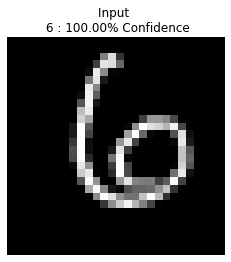

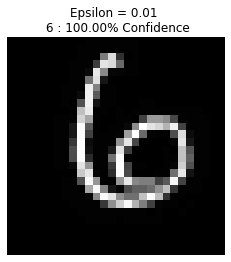

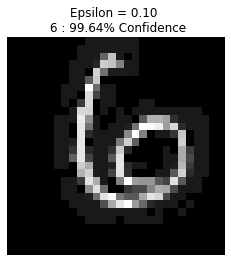

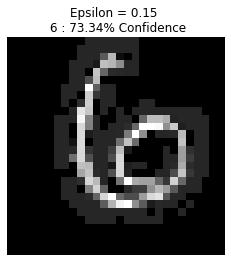

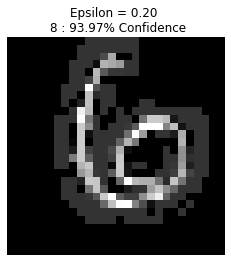

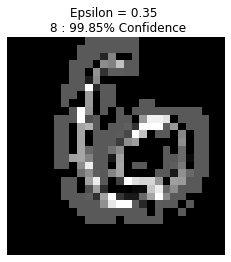

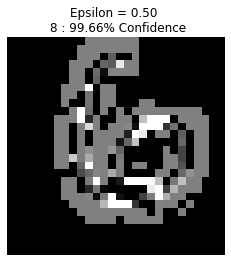

In [93]:
epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.35, 0.5]
descriptions = [('Epsilon = {:0.2f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adversarial_image = generate_adversarial_image(model, input_image, target_class = 8, epsilon = epsilons[i])
  display_images(adversarial_image, descriptions[i], model)

The effectiveness of the adversarial example depends on the target class $k$ and the norm 1 of its associated gradient $w_k = \nabla_x J_k$

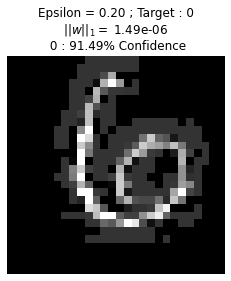

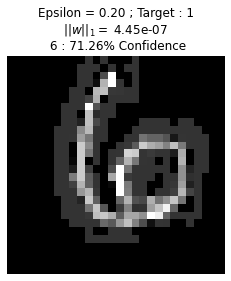

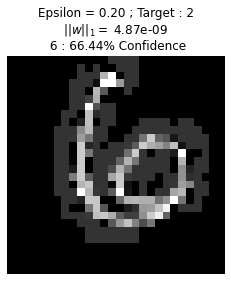

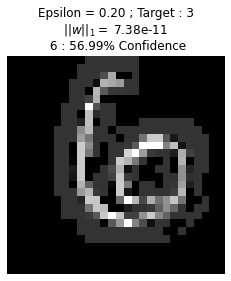

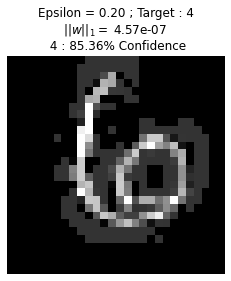

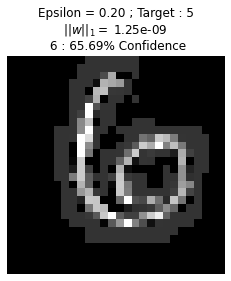

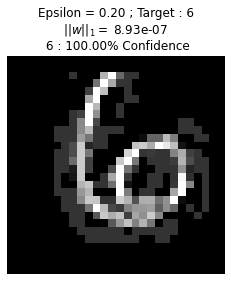

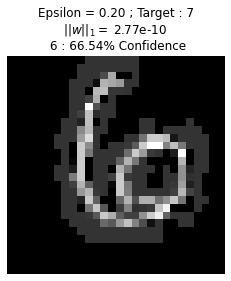

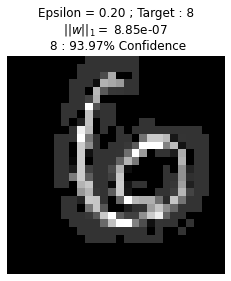

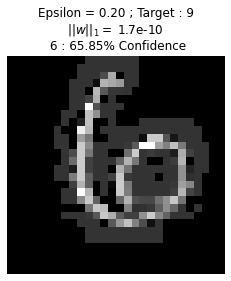

In [94]:
#Search for the worst 
for target_class in range(10):
  adversarial_image = generate_adversarial_image(model, input_image, target_class = target_class)
  gradient = compute_input_gradient(model, input_image, target_class)
  norm = np.sum(np.abs(gradient))
  display_images(adversarial_image, descriptions[4] + f' ; Target : {target_class}' + '\n' + f'$||w||_1 =$ {norm:.3}', model)


The effectiveness of the adversarial example depends on the input image and its associated confidence : if $y$ is small then a rather small perturbation can change the output.

3778


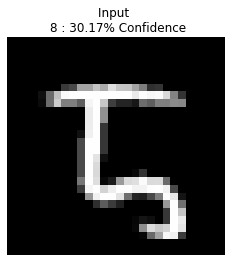

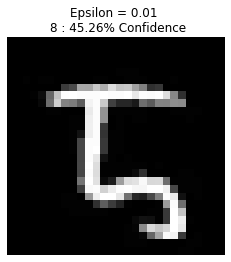

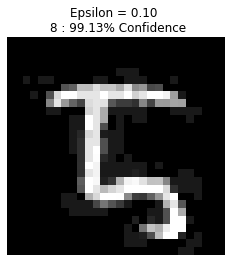

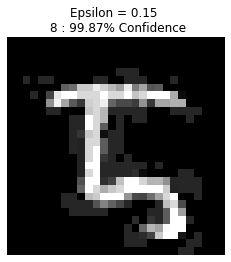

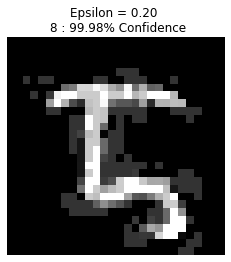

In [95]:
#search for the worst confidence 
i_worse = np.argmin(np.max(model(x_test),axis = 1))
print(i_worse)
new_input_image = x_test[i_worse]

for i, eps in enumerate(epsilons[:5]):
  adversarial_image = generate_adversarial_image(model, new_input_image, target_class = 8, epsilon = epsilons[i])
  display_images(adversarial_image, descriptions[i], model)

## Systematic approach
### Random target

In [139]:
import random as random

#define hyperparameters
n = 1200
eps = 0.2
error_rate = 0

#draw a random sample to make statistics
sample = random.sample(list(range(10000)), n)

#baseline 
ground_truth = y_test[sample]
output = np.argmax(model(x_test[sample]), axis = 1)
mask = np.equal(output, ground_truth)
baseline = np.count_nonzero(mask)/n
print(f'The success rate of the model on the random sample drawn from x_test is {100*baseline:.2f}%. \n The sample contains {n} elements')

#iterate over the sucess of the model
for i in np.array(sample)[mask]:
    
    #draw a random target, different from the ground truth
    target = random.sample( [k for k in range(10) if k != y_test[i]], 1)[0]

    #generate an adversarial image along this direction and check if it fooled the network
    adversarial_image = tf.convert_to_tensor(generate_adversarial_image(model, x_test[i], target_class = target, epsilon = eps))
    predicted_label = np.argmax(model(adversarial_image))
    if predicted_label != y_test[i]:
        error_rate += 1
error_rate /= (baseline*n)
print( f'Using a noise of maximum amplitude epsilon = {eps} the model is fooled {100*error_rate:.2f}% of the time ')


The success rate of the model on the random sample drawn from x_test is 98.50%. 
 The sample contains 1200 elements
Using a noise of maximum amplitude epsilon = 0.2 the model is fooled 63.62% of the time 


### Worse target

In [138]:
#define hyperparameters
n = 1200
eps = 0.2
error_rate = 0

#draw a random sample to make statistics
sample = random.sample(list(range(10000)), n)

#baseline 
ground_truth = y_test[sample]
output = np.argmax(model(x_test[sample]), axis = 1)
mask = np.equal(output, ground_truth)
baseline = np.count_nonzero(mask)/n
print(f'The success rate of the model on the random sample drawn from x_test is {100*baseline:.2f}%. \n The sample contains {n} elements')

#iterate over the sucess of the model
for i in np.array(sample)[mask]:
    
    #pick the worse target class
    norm_max = 0
    target = 0 
    for target_class in [k for k in range(10) if k != y_test[i]] :
        gradient = compute_input_gradient(model, x_test[i], target_class)
        norm = np.sum(np.abs(gradient))
        if norm_max < norm:
            norm_max = norm
            target = target_class

    #generate an adversarial image along this direction and check if it fooled the network
    adversarial_image = tf.convert_to_tensor(generate_adversarial_image(model, x_test[i], target_class = target, epsilon = eps))
    predicted_label = np.argmax(model(adversarial_image))
    if predicted_label != y_test[i]:
        error_rate += 1
error_rate /= (baseline*n)
print( f'Using a noise of maximum amplitude epsilon = {eps} the model is fooled {100*error_rate:.2f}% of the time ')

The success rate of the model on the random sample drawn from x_test is 98.00%. 
 The sample contains 1200 elements
Using a noise of maximum amplitude epsilon = 0.2 the model is fooled 89.37% of the time 


As explained in section 8 of "J. Goodfellow, Jonathon Shlens, and Christian Szegedy. Explaining and
Harnessing Adversarial Examples, 2015. arxiv: 1412.6572", adversarial example can generalize accross multiple model.

In [97]:
#more complex model
model2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 output classes (0-9)
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model2.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# # Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.3f}')

Epoch 1/5
844/844 [==============================] - 44s 42ms/step - loss: 0.2057 - accuracy: 0.9371 - val_loss: 0.0527 - val_accuracy: 0.9845
Epoch 2/5
844/844 [==============================] - 34s 41ms/step - loss: 0.0570 - accuracy: 0.9822 - val_loss: 0.0379 - val_accuracy: 0.9877
Epoch 3/5
844/844 [==============================] - 34s 40ms/step - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.0373 - val_accuracy: 0.9883
Epoch 4/5
844/844 [==============================] - 34s 41ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0286 - val_accuracy: 0.9917
Epoch 5/5
313/313 [==============================] - 2s 7ms/step - loss: 0.0278 - accuracy: 0.9914
Test accuracy: 0.991


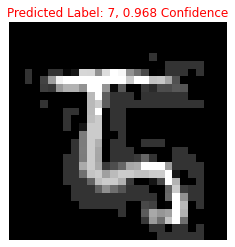

In [140]:
#we pick the worse target class for the worse image of the first model
norm_max = 0
target = 0 
for target_class in [k for k in range(10) if k != y_test[i_worse]] :
    gradient = compute_input_gradient(model, new_input_image, target_class)
    norm = np.sum(np.abs(gradient))
    if norm_max < norm:
        norm_max = norm
        target = target_class

#generate an adversarial image using the gradient of the simple model network
adv = generate_adversarial_image(model, new_input_image, 7, epsilon = 0.2)
adversarial_image_tensor = tf.convert_to_tensor(adv)

predictions = model2(adversarial_image_tensor)
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

plt.imshow(adv.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}, {confidence:.3f} Confidence', fontsize=12, color='red')

plt.show()